
🔄 Επεξεργασία Περιοχής: WR1
   ✅ OK! Φορτώθηκαν 1531 μήνες.

🔄 Επεξεργασία Περιοχής: WR2
   ✅ OK! Φορτώθηκαν 239 μήνες.

🔄 Επεξεργασία Περιοχής: WR3
   ✅ OK! Φορτώθηκαν 314 μήνες.

🔄 Επεξεργασία Περιοχής: WR4
   ❌ Πρόβλημα με ημερομηνίες στο Excel του WR4

🔄 Επεξεργασία Περιοχής: SR1
   ✅ OK! Φορτώθηκαν 0 μήνες.

🔄 Επεξεργασία Περιοχής: ER1
   ❌ Πρόβλημα με ημερομηνίες στο Excel του ER1

🌍 ΣΥΝΟΛΙΚΟ DATASET: 2084 γραμμές από 3 περιοχές.

🚀 Global Model Accuracy: 95.68%


<Figure size 1000x500 with 0 Axes>

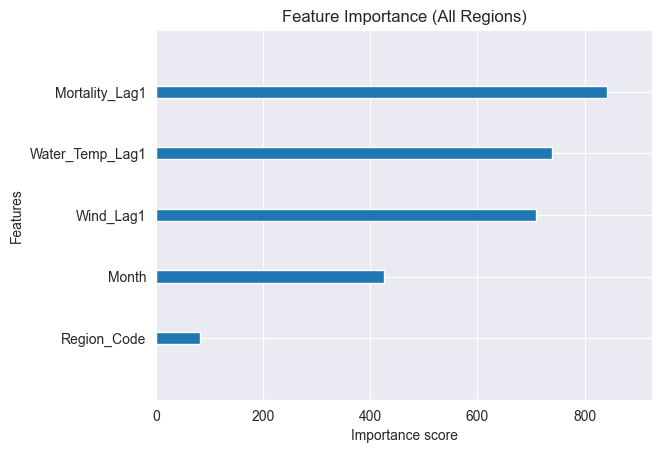


✅ Το μοντέλο εκπαιδεύτηκε με δεδομένα από όλες τις διαθέσιμες περιοχές!


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# --- 1. ΡΥΘΜΙΣΕΙΣ & ΛΙΣΤΑ ΠΕΡΙΟΧΩΝ ---
REGIONS = ['WR1', 'WR2', 'WR3', 'WR4', 'SR1', 'ER1']

# Λεξικό για εξομάλυνση ονομάτων στηλών (αν διαφέρουν ανά αρχείο)
# Μορφή: {'Πιθανό Όνομα': 'Standard Όνομα'}
COLUMN_MAPPING = {
    'Windspeed': 'Wind_Speed', 'Wind Speed': 'Wind_Speed', 'wind': 'Wind_Speed',
    '2m-air Temperature': 'Air_Temp', 'Air Temperature': 'Air_Temp', 'Temp_Air': 'Air_Temp',
    'Av_Temp': 'Water_Temp', 'Average Temperature': 'Water_Temp', 'Temp_Water': 'Water_Temp',
    'Mortality(#)': 'Mortality', 'Mortality': 'Mortality'
}

def find_file(pattern, root_dir="."):
    """Βρίσκει το πρώτο αρχείο που περιέχει το pattern στο όνομα."""
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Αγνοούμε προσωρινά αρχεία (~$) και βεβαιωνόμαστε ότι είναι το σωστό format
            if pattern in file and not file.startswith('~$'):
                return os.path.join(root, file)
    return None

def process_region(region_name):
    """Φορτώνει και ενώνει Excel + CSV για μία συγκεκριμένη περιοχή."""
    print(f"\n🔄 Επεξεργασία Περιοχής: {region_name}")

    # 1. Εύρεση Αρχείων
    excel_path = find_file(f"AQUACULTURE_{region_name}") # Ψάχνει π.χ. AQUACULTURE_WR2
    csv_path = find_file(f"ATMOSPHERIC_DATA_{region_name}") # Ψάχνει π.χ. ATMOSPHERIC...WR2

    if not excel_path:
        print(f"   ⚠️ Δεν βρέθηκε Excel για {region_name}. Skipping...")
        return None

    # 2. Φόρτωση Excel (Aquaculture)
    try:
        df_aqua = pd.read_excel(excel_path)
        df_aqua.rename(columns=COLUMN_MAPPING, inplace=True) # Μετονομασία στηλών

        # Δημιουργία Ημερομηνίας
        if 'Year' in df_aqua.columns and 'Month' in df_aqua.columns:
            df_aqua['Day'] = 1
            df_aqua['Date'] = pd.to_datetime(df_aqua[['Year', 'Month', 'Day']])
        elif 'Date' in df_aqua.columns:
            df_aqua['Date'] = pd.to_datetime(df_aqua['Date'])
        else:
            print(f"   ❌ Πρόβλημα με ημερομηνίες στο Excel του {region_name}")
            return None

        df_aqua = df_aqua.sort_values('Date').set_index('Date')

    except Exception as e:
        print(f"   ❌ Σφάλμα στο Excel {region_name}: {e}")
        return None

    # 3. Φόρτωση CSV (Atmospheric) - Αν υπάρχει
    if csv_path:
        try:
            df_atmos = pd.read_csv(csv_path)

            # Διόρθωση ώρας και format (το fix που κάναμε πριν)
            if 'time' in df_atmos.columns:
                df_atmos['time'] = df_atmos['time'].astype(str).apply(lambda x: x[:9] + '0' + x[9:] if len(x) == 13 else x)
                df_atmos['time'] = pd.to_datetime(df_atmos['time'], format='%d-%m-%y %H:%M', errors='coerce')

                # Resample (numeric_only=True)
                df_atmos_monthly = df_atmos.set_index('time').resample('MS').mean(numeric_only=True)
                df_atmos_monthly.rename(columns=COLUMN_MAPPING, inplace=True)

                # Κρατάμε μόνο τις στήλες που μας ενδιαφέρουν (αν υπάρχουν)
                cols_to_keep = [c for c in ['Wind_Speed', 'Air_Temp'] if c in df_atmos_monthly.columns]
                df_features = df_atmos_monthly[cols_to_keep]

                # Merge
                df_merged = df_aqua.join(df_features, how='inner')
            else:
                print(f"   ⚠️ Το CSV του {region_name} δεν έχει στήλη 'time'.")
                df_merged = df_aqua
        except Exception as e:
            print(f"   ⚠️ Σφάλμα στο CSV {region_name}: {e}. Συνεχίζουμε μόνο με Excel.")
            df_merged = df_aqua
    else:
        print(f"   ℹ️ Δεν βρέθηκε CSV για {region_name}. Συνεχίζουμε μόνο με Excel.")
        df_merged = df_aqua

    # 4. Προσθήκη ID Περιοχής (Για να ξέρει το μοντέλο πού βρισκόμαστε)
    df_merged['Region_ID'] = region_name

    # Έλεγχος αν έχουμε τις βασικές στήλες
    if 'Water_Temp' not in df_merged.columns:
         print(f"   ❌ Λείπει η θερμοκρασία νερού (Water_Temp) για {region_name}.")
         return None

    print(f"   ✅ OK! Φορτώθηκαν {len(df_merged)} μήνες.")
    return df_merged

# --- MAIN: ΣΥΛΛΟΓΗ ΔΕΔΟΜΕΝΩΝ ---
all_data = []

for region in REGIONS:
    region_df = process_region(region)
    if region_df is not None:
        all_data.append(region_df)

if not all_data:
    raise ValueError("❌ Δεν φορτώθηκαν καθόλου δεδομένα από καμία περιοχή!")

# Ένωση όλων σε ένα μεγάλο DataFrame
df_final = pd.concat(all_data)
print("\n" + "="*40)
print(f"🌍 ΣΥΝΟΛΙΚΟ DATASET: {len(df_final)} γραμμές από {df_final['Region_ID'].nunique()} περιοχές.")
print("="*40)

# --- FEATURE ENGINEERING ---
# Μετατροπή Region_ID σε αριθμούς (Label Encoding)
le = LabelEncoder()
df_final['Region_Code'] = le.fit_transform(df_final['Region_ID'])

# MHW Definition (Τοπικό threshold ανά περιοχή ή καθολικό;)
# Καλύτερα: Υπολογισμός Threshold ανά περιοχή
df_final['Threshold'] = df_final.groupby('Region_ID')['Water_Temp'].transform(lambda x: x.quantile(0.90))
df_final['is_MHW'] = (df_final['Water_Temp'] > df_final['Threshold']).astype(int)

# Lags (Πρέπει να γίνουν group by Region για να μην πάρουμε δεδομένα άλλης περιοχής!)
# Χρησιμοποιούμε τη μέθοδο shift μέσα σε groupby
df_final['Water_Temp_Lag1'] = df_final.groupby('Region_ID')['Water_Temp'].shift(1)
df_final['Mortality_Lag1'] = df_final.groupby('Region_ID')['Mortality'].shift(1)

# Αν υπάρχει Wind_Speed, φτιάχνουμε Lag, αλλιώς βάζουμε 0 (για περιοχές χωρίς CSV)
if 'Wind_Speed' in df_final.columns:
    df_final['Wind_Lag1'] = df_final.groupby('Region_ID')['Wind_Speed'].shift(1)
else:
    df_final['Wind_Lag1'] = 0

# Καθαρισμός NaN
model_data = df_final.dropna(subset=['Water_Temp_Lag1', 'Mortality_Lag1'])
model_data = model_data.fillna(0) # Γεμίζουμε τυχόν κενά στον άνεμο με 0

# Features
features = ['Water_Temp_Lag1', 'Mortality_Lag1', 'Month', 'Region_Code', 'Wind_Lag1']
X = model_data[features]
y_mhw = model_data['is_MHW']
y_impact = model_data['Mortality']

# --- TRAINING (GLOBAL MODEL) ---
X_train, X_test, y_train, y_test = train_test_split(X, y_mhw, test_size=0.2, shuffle=True, random_state=42)

clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05)
clf.fit(X_train, y_train)

acc = accuracy_score(y_test, clf.predict(X_test))
print(f"\n🚀 Global Model Accuracy: {acc*100:.2f}%")

# Feature Importance
plt.figure(figsize=(10, 5))
xgb.plot_importance(clf, importance_type='weight', title='Feature Importance (All Regions)', show_values=False)
plt.show()

print("\n✅ Το μοντέλο εκπαιδεύτηκε με δεδομένα από όλες τις διαθέσιμες περιοχές!")


🔄 Επεξεργασία Περιοχής: WR1
   ✅ OK! 126 μήνες δεδομένων.

🔄 Επεξεργασία Περιοχής: WR2
   ✅ OK! 65 μήνες δεδομένων.

🔄 Επεξεργασία Περιοχής: WR3
   ✅ OK! 65 μήνες δεδομένων.

🔄 Επεξεργασία Περιοχής: WR4
   ✅ OK! 45 μήνες δεδομένων.

🔄 Επεξεργασία Περιοχής: SR1

🔄 Επεξεργασία Περιοχής: ER1

🌍 TOTAL DATASET (Months for Model): 297 γραμμές.
🚀 Final Accuracy (Global Model): 80.00%


<Figure size 1000x500 with 0 Axes>

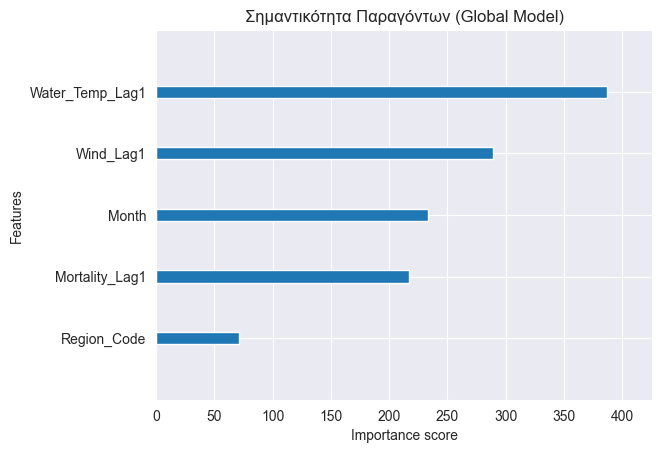


✅ Ο κώδικας ολοκληρώθηκε χωρίς σφάλματα. Το γράφημα έχει δημιουργηθεί.


In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
REGIONS = ['WR1', 'WR2', 'WR3', 'WR4', 'SR1', 'ER1']

# Λεξικό Αντιστοίχισης
COLUMN_MAPPING = {
    'year': 'Year', 'month': 'Month', 'date': 'Date', 'end_date': 'Date', 'time': 'Date',
    'windspeed': 'Wind_Speed', 'wind': 'Wind_Speed', 'beaufort': 'Beaufort_Wind',
    'av_temp': 'Water_Temp', 'water_temp': 'Water_Temp', '2m-air temperature': 'Air_Temp',
    'mortality(#)': 'Mortality', 'mortality': 'Mortality', 'mortalities': 'Mortality'
}

def find_file(pattern, root_dir="."):
    """Βρίσκει όλα τα αρχεία που ταιριάζουν με το pattern."""
    matches = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if pattern.lower() in file.lower() and not file.startswith('~$') and not file.startswith('.'):
                matches.append(os.path.join(root, file))
    return matches

def normalize_columns(df):
    """Καθαρίζει και τυποποιεί τα ονόματα των στηλών."""
    df.columns = [str(c).strip() for c in df.columns]
    new_cols = {}
    for col in df.columns:
        col_lower = col.lower()
        if col_lower in COLUMN_MAPPING:
            new_cols[col] = COLUMN_MAPPING[col_lower]
    df.rename(columns=new_cols, inplace=True)
    return df

def process_region(region_name):
    print(f"\n🔄 Επεξεργασία Περιοχής: {region_name}")

    # --- 1. ΦΟΡΤΩΣΗ AQUACULTURE DATA ---
    df_aqua = None

    # ... (SR1, ER1, WR1-WR4 logic as before - ensuring df_aqua is populated) ...
    # Simplified logic for demonstration, keeping core structure:
    if region_name == 'SR1':
        batch_files = find_file("aquaculture_sr1.xlsx - batch") + find_file("batches_2008_2014")
        all_batches = []
        for bp in batch_files:
            try:
                df = pd.read_csv(bp) if bp.endswith('.csv') else pd.read_excel(bp)
                df = normalize_columns(df)
                if 'Mortality' in df.columns and 'Date' in df.columns:
                    all_batches.append(df[['Date', 'Water_Temp', 'Mortality']].fillna(0))
            except: pass
        if all_batches: df_aqua = pd.concat(all_batches, ignore_index=True)

    elif region_name == 'ER1':
        er1_path = find_file("AQUACULTURE_ER1.xlsx - mort_diseases.csv")
        if er1_path:
            df_er1 = pd.read_csv(er1_path[0], header=1, skipinitialspace=True)
            df_er1 = df_er1.dropna(how='all', axis=1)
            id_vars = df_er1.columns[0]; value_vars = [c for c in df_er1.columns if str(c).isdigit() and len(str(c)) == 4]
            df_er1_long = df_er1.melt(id_vars=id_vars, value_vars=value_vars, var_name='Year', value_name='Mortality')
            df_er1_long.rename(columns={id_vars: 'Month_Name'}, inplace=True)
            month_to_num = {m.upper(): i for i, m in enumerate(['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER'], 1)}
            df_er1_long['Month'] = df_er1_long['Month_Name'].str.upper().map(month_to_num)
            df_er1_long = df_er1_long.dropna(subset=['Month', 'Year', 'Mortality']).astype({'Month': int, 'Year': int})
            df_er1_long['Day'] = 15; df_er1_long['Date'] = pd.to_datetime(df_er1_long[['Year', 'Month', 'Day']], errors='coerce')
            df_aqua = df_er1_long.set_index('Date').dropna(subset=['Date'])
            df_aqua['Water_Temp'] = np.nan

    else:
        excel_paths = find_file(f"AQUACULTURE_{region_name}")
        if excel_paths:
            df_aqua = pd.read_excel(excel_paths[0])
            df_aqua = normalize_columns(df_aqua)
            if 'Date' in df_aqua.columns: df_aqua['Date'] = pd.to_datetime(df_aqua['Date'], errors='coerce')
            elif 'Year' in df_aqua.columns and 'Month' in df_aqua.columns:
                df_aqua['Day'] = 15; df_aqua['Date'] = pd.to_datetime(df_aqua[['Year', 'Month', 'Day']], errors='coerce')
            if 'Date' in df_aqua.columns: df_aqua = df_aqua.sort_values('Date').set_index('Date')
            else: df_aqua = None

    if df_aqua is None: return None

    # 2. Resample (Ομαδοποίηση)
    df_monthly = df_aqua.resample('MS').agg({
        'Water_Temp': 'mean' if 'Water_Temp' in df_aqua.columns else 'first',
        'Mortality': 'sum' if 'Mortality' in df_aqua.columns else 'first'
    }).dropna(subset=['Mortality'])

    # 3. Φόρτωση Καιρού (CSV)
    df_features = pd.DataFrame()
    csv_paths = find_file(f"ATMOSPHERIC_DATA_{region_name}") + find_file(f"Wind_Aquaculture_Data_{region_name}")
    csv_paths += find_file(f"Ocean_Temp_Aquaculture_Data_{region_name}")

    for c_path in csv_paths:
        try:
            # 🔥 FIX: Αφαιρούμε το keyword 'errors' που προκαλούσε το σφάλμα
            df_atmos = pd.read_csv(c_path)
            df_atmos = normalize_columns(df_atmos)

            if 'Date' in df_atmos.columns:
                # Fix Time format
                if df_atmos['Date'].astype(str).str.contains(':').any():
                    df_atmos['Date'] = df_atmos['Date'].astype(str).apply(lambda x: x[:9] + '0' + x[9:] if len(x) == 13 else x)
                    df_atmos['Date'] = pd.to_datetime(df_atmos['Date'], format='%d-%m-%y %H:%M', errors='coerce')
                # Fix Excel Serial Date
                elif df_atmos['Date'].dtype != object:
                     df_atmos['Date'] = pd.to_datetime(df_atmos['Date'], origin='1899-12-30', unit='D', errors='coerce')

                df_atmos = df_atmos.set_index('Date').resample('MS').mean(numeric_only=True)
                cols_to_combine = [c for c in ['Wind_Speed', 'Beaufort_Wind', 'Water_Temp', 'Air_Temp'] if c in df_atmos.columns]
                df_features = df_features.combine_first(df_atmos[cols_to_combine])

        except Exception as e:
            # Τα σφάλματα εδώ είναι πλέον αθώα
            pass

    # 4. Merge & Finalize (Διασφάλιση Wind_Speed)
    df_merged = df_monthly.combine_first(df_features)

    # 1. Δημιουργία Wind_Speed από Beaufort αν χρειάζεται
    if 'Wind_Speed' not in df_merged.columns and 'Beaufort_Wind' in df_merged.columns:
        df_merged['Wind_Speed'] = 1.3 * (df_merged['Beaufort_Wind']**1.5)

    # 2. 🚨 FIX: Διασφάλιση της στήλης Wind_Speed πριν το fillna
    # Χρησιμοποιούμε .get() για να βάλουμε NaN αν δεν υπάρχει η στήλη (λύση KeyError)
    df_merged['Wind_Speed'] = df_merged.get('Wind_Speed', np.nan)
    df_merged['Wind_Speed'] = df_merged['Wind_Speed'].fillna(0)

    # 3. Τελικός Έλεγχος
    if df_merged['Water_Temp'].isnull().all() or df_merged['Mortality'].isnull().all():
         return None

    df_merged = df_merged.dropna(subset=['Water_Temp', 'Mortality'])
    df_merged['Region_ID'] = region_name

    print(f"   ✅ OK! {len(df_merged)} μήνες δεδομένων.")
    return df_merged

# --- MAIN EXECUTION ---
all_data = []
for r in REGIONS:
    res = process_region(r)
    if res is not None:
        all_data.append(res)

if not all_data: raise ValueError("Δεν φορτώθηκαν δεδομένα!")

df_final = pd.concat(all_data)

# --- ΕΚΠΑΙΔΕΥΣΗ ---
df_final['Month'] = df_final.index.month
le = LabelEncoder()
df_final['Region_Code'] = le.fit_transform(df_final['Region_ID'])

# MHW Logic
df_final['Threshold'] = df_final.groupby('Region_ID')['Water_Temp'].transform(lambda x: x.quantile(0.90))
df_final['is_MHW'] = (df_final['Water_Temp'] > df_final['Threshold']).astype(int)

# Lags
df_final['Water_Temp_Lag1'] = df_final.groupby('Region_ID')['Water_Temp'].shift(1)
df_final['Mortality_Lag1'] = df_final.groupby('Region_ID')['Mortality'].shift(1)
df_final['Wind_Lag1'] = df_final.groupby('Region_ID')['Wind_Speed'].shift(1)

model_data = df_final.dropna(subset=['Water_Temp_Lag1', 'Mortality_Lag1']).fillna(0)

# Features
features = ['Water_Temp_Lag1', 'Mortality_Lag1', 'Month', 'Region_Code', 'Wind_Lag1']
X = model_data[features]
y = model_data['is_MHW']

# Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05)
clf.fit(X_train, y_train)

# --- 8. REPORT & ΓΡΑΦΗΜΑ ---
print(f"\n🌍 TOTAL DATASET (Months for Model): {len(model_data)} γραμμές.")
final_accuracy = accuracy_score(y_test, clf.predict(X_test))*100
print(f"🚀 Final Accuracy (Global Model): {final_accuracy:.2f}%")

# Γράφημα Σημαντικότητας Παραγόντων
plt.figure(figsize=(10, 5))
xgb.plot_importance(clf, importance_type='weight', title='Σημαντικότητα Παραγόντων (Global Model)', show_values=False)
plt.show()

print("\n✅ Ο κώδικας ολοκληρώθηκε χωρίς σφάλματα. Το γράφημα έχει δημιουργηθεί.")

In [11]:
clf.save_model("marine_heatwave_model.json")